# Análise Inferencial e Seleção de Atributos (Português)

> Objetivo: Realizar uma análise inferencial e uma seleção criteriosa de atributos com base em testes estatísticos, análise de multicolinearidade e regressões lineares, a fim de identificar os fatores mais relevantes para o desempenho acadêmico em Língua Portuguesa.


#### Configurações Iniciais

###### ajustar o path

In [1]:
# HIDE
import sys
import pathlib

path = pathlib.Path().resolve()
while path.name != 'student_perfomance_tcc' and path != path.parent:
    path = path.parent

# Adicionar a raiz ao sys.path para importar o módulo
if str(path) not in sys.path:
    sys.path.append(str(path))

from ajustar_path import adicionar_modulos_ao_path

# Adiciona a pasta 'modulos' ao path
adicionar_modulos_ao_path()

## 1. Bibliotecas, Módulos e Configurações Iniciais

In [2]:
#Importação dos módulos desenvolvidos

from modulos.pre_modelagem import importar_base, preparar_dados
from modulos.eda_functions import *
from modulos.feature_selection import( ajustar_regressao,
                                       stepwise_selection,
                                       avaliar_residuos_regressao,
                                       selecionar_nominais_relevantes,
                                       selecionar_ordinais_relevantes,
                                       relatorio_multicolinearidade,
                                       regressao_multipla,
                                       comparar_modelos_regressao
                                       
                                     )

# Bibliotecas

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor
import shap

import seaborn as sns
import matplotlib.pyplot as plt

import warnings

# Ignora todos os warnings
warnings.filterwarnings('ignore')


# 1. Importação da Base e Pré-Modelagem

In [3]:
#Importação da base

materia =  'portugues' 

cor_paleta = 'azul' 

# Trabalhando apenas com o conjunto de treino (df_t)
# para evitar qualquer tipo de vazamento de dados nas etapas de análise inferencial e seleção de atributos

df_t = pd.read_csv('data\dados_treino_portugues_rs42.csv')

df = df_t.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 34 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   escola                        454 non-null    object
 1   genero                        454 non-null    object
 2   idade                         454 non-null    int64 
 3   endereco                      454 non-null    object
 4   tamanho_familia               454 non-null    object
 5   status_parental               454 non-null    object
 6   escolaridade_mae              454 non-null    int64 
 7   escolaridade_pai              454 non-null    int64 
 8   profissao_mae                 454 non-null    object
 9   profissao_pai                 454 non-null    object
 10  motivo_escolha_escola         454 non-null    object
 11  responsavel_legal             454 non-null    object
 12  tempo_transporte              454 non-null    int64 
 13  tempo_estudo        

# 2. Síntese Inicial com Base na EDA

A EDA foi conduzida exclusivamente no conjunto de treinamento da base de Português, com o objetivo de gerar hipóteses preliminares sobre atributos potencialmente relevantes. Os achados listados a seguir orientam, mas **não determinam**, as escolhas de atributos para modelagem. A formalização será feita através de análises inferenciais neste notebook.

- As variáveis de nota apresentaram **distribuições não normais** (teste de Shapiro-Wilk).
- Certas variáveis categóricas demonstraram **associação visual com aprovação**, sugerindo possível relação com o desempenho.
- A **multicolinearidade será avaliada** com VIF e análise de correlação entre preditores.



In [5]:
selecao_baseada_em_eda_por = [
    "faltas", "idade",
    "reprovacoes", "tempo_estudo", "interesse_ensino_superior", "escolaridade_mae",
    "alcool_dias_uteis", "apoio_escolar", "frequencia_saidas", "escola",
    "apoio_familiar", "relacao_familiar", "acesso_internet",
    "genero", "atividades_extracurriculares"]

# 3. Avaliação de Multicolinearidade

A multicolinearidade ocorre quando dois ou mais preditores apresentam alta correlação entre si, o que pode dificultar a interpretação dos coeficientes em modelos lineares, inflar os erros padrão e comprometer a estabilidade estatística.

Nesta etapa, avaliamos a presença de multicolinearidade entre os preditores por meio de:

- **Coeficiente de correlação de Pearson** entre pares de variáveis (limite: |r| > 0.6).
- **Fator de Inflação da Variância (VIF)**, com foco em VIF > 5 (alerta) e VIF > 10 (crítico).

> ###### *Todos os cálculos são realizados **apenas no conjunto de treino**, conforme boas práticas para evitar vazamento de dados.*


In [6]:
# Pré-processamento: remoção da variável-alvo e preparação dos dados
variaveis_target = ['nota1', 'nota2', 'nota_final']

# Garante que apenas preditores sejam analisados
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'])  # df é o conjunto de treino
df_preditores = df_pp.drop(columns=variaveis_target)

# Avaliação de multicolinearidade
print('Limiar coeficiente de correlação > 0.6')
resumo, vif_df = relatorio_multicolinearidade(df_preditores, limite_corr=0.6)

# Mostra apenas os casos com alerta
display(resumo[resumo['avaliacao'] != 'Sem alerta'])



Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (454, 42)
Limiar coeficiente de correlação > 0.6


,variavel_1,variavel_2,correlacao
5,escolaridade_pai,escolaridade_mae,0.646166
189,alcool_fim_semana,alcool_dias_uteis,0.619031
526,profissao_pai_Serviços,profissao_pai_Outra profissão,0.719559


,variavel,vif,Alta correlação com,avaliacao
0,idade,75.654341,—,VIF elevado
15,relacao_familiar,19.261987,—,VIF elevado
2,escolaridade_mae,17.177610,escolaridade_pai,VIF alto + correlação alta
16,tempo_livre,12.316866,—,VIF elevado
12,interesse_ensino_superior,12.242786,—,VIF elevado
17,frequencia_saidas,12.123667,—,VIF elevado
3,escolaridade_pai,12.055253,escolaridade_mae,VIF alto + correlação alta
30,profissao_pai_Outra profissão,10.307217,profissao_pai_Serviços,VIF alto + correlação alta
5,tempo_estudo,8.324402,—,VIF elevado
19,alcool_fim_semana,8.245935,alcool_dias_uteis,VIF alto + correlação alta


### Principais achados

- Foram identificados **três pares de variáveis com correlação acima de 0.60**:
  - `escolaridade_pai` e `escolaridade_mae` (r = 0.65)
  - `alcool_fim_semana` e `alcool_dias_uteis` (r = 0.62)
  - `profissao_pai_Serviços` e `profissao_pai_Outra profissão` (r = 0.72)

- **Quinze variáveis apresentaram VIF > 5**, sendo que oito delas superaram o limiar crítico de 10. Destaques:
  - `idade` (VIF = 75.65)
  - `relacao_familiar`, `tempo_livre`, `interesse_ensino_superior`, `frequencia_saidas` (VIF entre 12–19)
  - `escolaridade_mae` e `escolaridade_pai` com VIFs > 12 e alta correlação entre si
  - `alcool_fim_semana` e `alcool_dias_uteis` com VIFs > 7 e alta correlação entre si

- Algumas variáveis foram **mantidas por critérios teóricos** e interpretabilidade, mesmo com VIF elevado:
  - `escolaridade_mae` (preferida à paterna)
  - `alcool_dias_uteis` (preferida ao uso no fim de semana)
  - `interesse_ensino_superior` e `frequentou_creche` (mantidas por contexto educacional)

- As variáveis **candidatas à remoção por redundância estatística** incluem:
  - `escolaridade_pai`, `alcool_fim_semana`, `profissao_pai_Outra profissão` e `profissao_pai_Serviços`

Essas decisões serão refletidas nas regressões a seguir, priorizando estabilidade estatística, parcimônia e coerência teórica.


In [7]:
variaveis_alta_colineariedade_descarte = [
            'escolaridade_pai',
            'alcool_fim_semana',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]
variaveis_alta_colineariedade = [
            'escolaridade_pai',
            'escolaridade_mae',
            'alcool_fim_semana',
            'alcool_dias_uteis',
            'profissao_pai_Outra profissão',
            'profissao_pai_Serviços'
        ]

In [8]:
corr = df_pp[variaveis_alta_colineariedade + variaveis_target].corr()

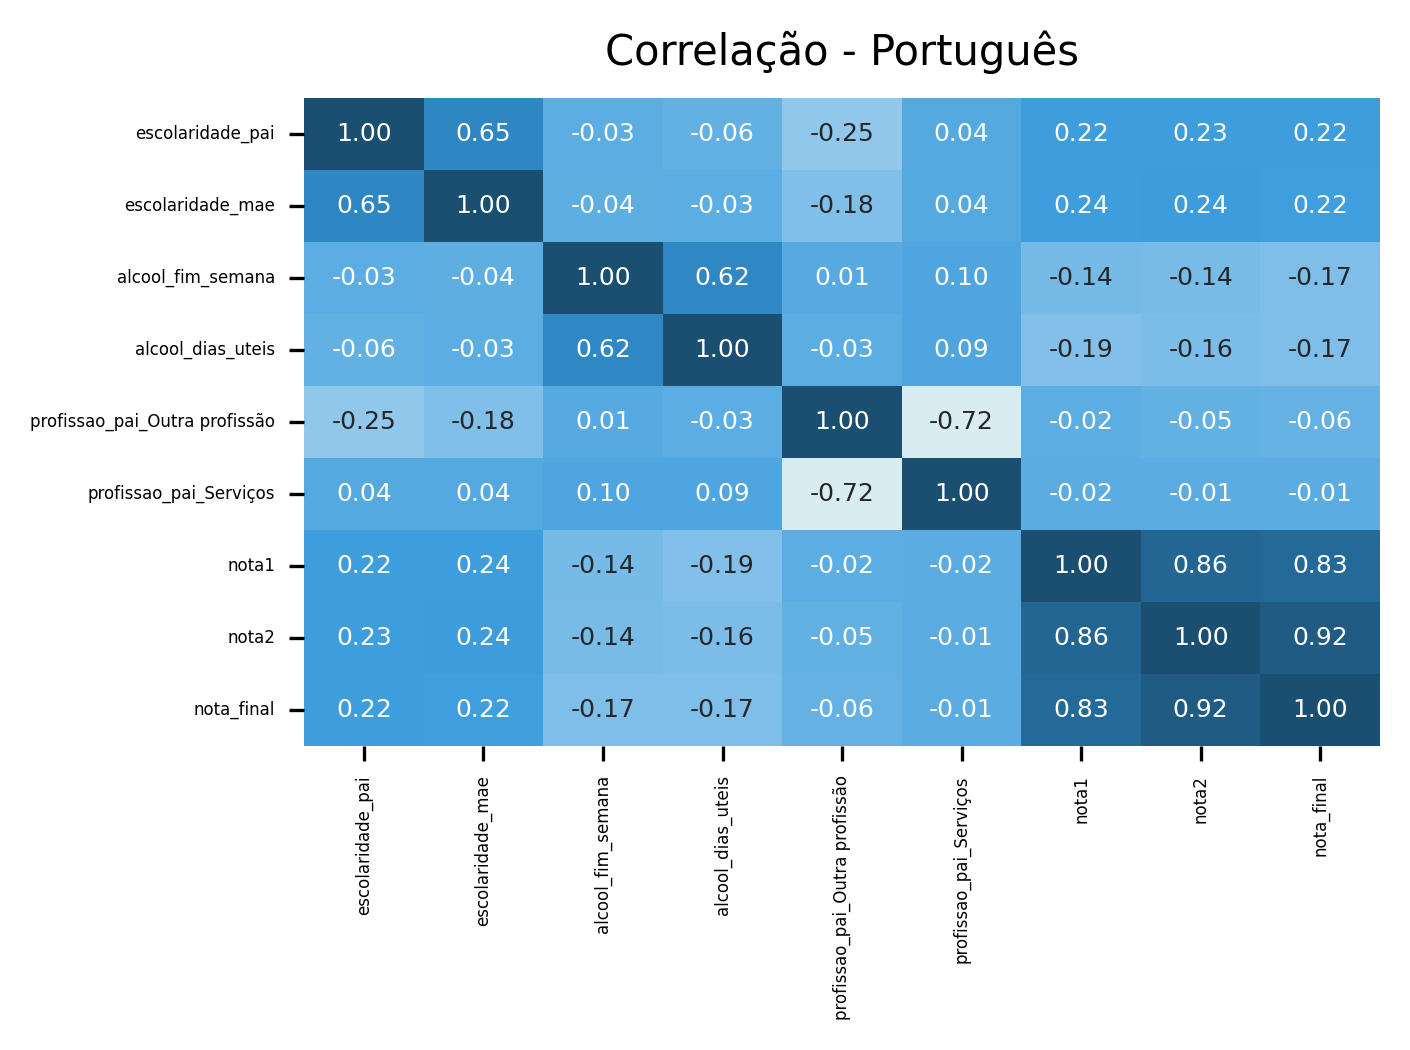

In [9]:
custom_heatmap(disciplina=materia,cores=cor_paleta,matriz_corr=corr, n_arq='corr_multicol',titulo='Correlação')

O mapa de calor acima reforça os padrões de colinearidade identificados numericamente:

- `profissao_pai_Serviços` e `profissao_pai_Outra profissão` apresentam uma **correlação fortemente negativa** (-0.72), o que indica redundância entre essas categorias dummies.
- `nota1`, `nota2` e `nota_final` exibem **correlações muito altas entre si** (acima de 0.83), o que é esperado pela progressão das avaliações ao longo do ano.
- `escolaridade_pai` e `escolaridade_mae` têm correlação moderada (0.65), o que sugere interdependência no nível educacional dos responsáveis.
- `alcool_fim_semana` e `alcool_dias_uteis` apresentam correlação positiva moderada.

# 4. Regressão: Da Nota 1 à Nota 2 – Avaliação de Fatores Explicativos

Esta seção busca investigar os fatores associados à nota intermediária (`nota2`) por meio de modelos de regressão linear. Inicialmente, avaliamos o impacto isolado da `nota1`, seguida da inclusão de variáveis contextuais e socioeducacionais com base nos atributos do conjunto de treino.

As etapas incluem:

- Regressão simples: `nota1` como único preditor.
- Regressão múltipla com variáveis selecionadas por diferentes critérios (p-valor, stepwise, VIF).
- Avaliação dos resíduos e suposições do modelo.
- Comparação entre os modelos quanto ao desempenho e parcimônia.



## 4.1. Modelo simples (nota1)
- Objetivo: Verificar a relação direta entre nota1 e nota2.
- Avaliar o comportamento dos coeficientes e resíduos.

In [10]:
#Pré processamento

df_pp = preparar_dados(df, columns_to_drop=['aprovacao','nota_final'],target_column='nota2')

Removendo colunas: ['aprovacao', 'nota_final']
Shape final do DataFrame preparado: (454, 41)


In [11]:
modelo_n2_1, X_wc, y = regressao_multipla(df_pp, target='nota2', variaveis=['nota1'])

## 4.2. Regressão múltipla com nota1 e variáveis adicionais

**Objetivo:** Avaliar a estabilidade do coeficiente associado à `nota1` na presença de outros preditores e identificar covariáveis explicativas adicionais associadas ao desempenho na `nota2`.


### 4.2.1 Modelo completo (sem seleção de atributos)
Foi ajustado um modelo com todas as variáveis disponíveis, exceto a variável-alvo `nota2`.


In [12]:
# Ajuste do modelo completo (sem seleção de atributos)
aux_drop = ['nota2']
variaveis_completas = list(set(df_pp.columns) - set(aux_drop))

modelo_n2_2, X_completo, y_completo = regressao_multipla(
    df_pp,
    target='nota2',
    variaveis=variaveis_completas
)



### 4.2.2 Seleção dos 15 atributos com menor p-valor
Com base no modelo completo, selecionou-se as 15 variáveis com menor p-valor.


In [13]:
X_top15, y_top15, modelo_top15, top_15_var = ajustar_regressao(
    df=df_pp,
    target_column='nota2',
    top_n=15
)


--- Sumário do Modelo de Regressão OLS ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     33.05
Date:                Wed, 14 May 2025   Prob (F-statistic):          2.14e-104
Time:                        21:36:41   Log-Likelihood:                -799.09
No. Observations:                 454   AIC:                             1680.
Df Residuals:                     413   BIC:                             1849.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

,Coef.,Std.Err.,t,P>|t|
nota1,0.863,0.032,26.568,2.06e-91
reprovacoes,-0.426,0.133,-3.204,0.001
relacao_familiar,0.212,0.076,2.791,0.005
idade,0.177,0.069,2.561,0.011
relacionamento_romantico,-0.342,0.152,-2.258,0.024
saude,-0.099,0.052,-1.907,0.057
aulas_particulares,0.457,0.344,1.326,0.186
responsavel_legal_Pai,-0.234,0.181,-1.297,0.195
apoio_escolar,0.313,0.249,1.254,0.21
tempo_livre,-0.087,0.075,-1.164,0.245


-----------------------------------------------

Atributos de maior relevância (por P-valor):
1. nota1
2. reprovacoes
3. relacao_familiar
4. idade
5. relacionamento_romantico
6. saude
7. aulas_particulares
8. responsavel_legal_Pai
9. apoio_escolar
10. tempo_livre
11. profissao_mae_Professor(a)
12. profissao_mae_Serviços
13. profissao_pai_Outra profissão
14. alcool_fim_semana
15. alcool_dias_uteis


In [14]:
# Ajuste da regressão com os 15 atributos mais relevantes por p-valor
variaveis_15 = top_15_var
target = 'nota2'

modelo_n2_3, X_top15, y_top15 = regressao_multipla(df_pp[variaveis_15 + [target]], 
                                                   target=target, 
                                                   variaveis=variaveis_15)



### 4.2.3 Ajustes por multicolinearidade

A partir dos 15 atributos, foram removidas variáveis redundantes estatisticamente, como:

- `escolaridade_pai` (mantida a materna por valor teórico),
- `profissao_pai_Serviços` (avaliada isoladamente com e sem `profissao_pai_Outra profissão`).

Também foi testada a **inclusão específica da variável `faltas`**, dada sua relevância observada em análises anteriores, mesmo não aparecendo entre os 15 menores p-valores iniciais.

In [15]:
# Identificação das variáveis colineares entre os 15 melhores atributos
colineares_top15 = list(set(top_15_var) & set(variaveis_alta_colineariedade))
print("Variáveis com alta colinearidade dentro do top 15:", colineares_top15)

# Modelo com exclusão de variáveis colineares (ex: profissao_pai_Outra profissão)
variaveis_sem_colinear = list(set(top_15_var) - set(['profissao_pai_Outra profissão']))

modelo_n2_4, X_n2_4, y_n2_4 = regressao_multipla(
    df=df_pp[variaveis_sem_colinear + ['nota2']],
    target='nota2',
    variaveis=variaveis_sem_colinear
)



Variáveis com alta colinearidade dentro do top 15: ['alcool_fim_semana', 'profissao_pai_Outra profissão', 'alcool_dias_uteis']


In [16]:
# Modelo com inclusão manual da variável 'faltas' (avaliada previamente como relevante)
variaveis_com_faltas = variaveis_sem_colinear + ['faltas']

modelo_n2_5, X_n2_5, y_n2_5 = regressao_multipla(
    df=df_pp[variaveis_com_faltas + ['nota2']],
    target='nota2',
    variaveis=variaveis_com_faltas
)




### 4.2.4 Seleção stepwise (AIC e BIC)

Aplicou-se seleção stepwise com critérios AIC e BIC

In [17]:
variaveis_sem_nota = df_pp.drop(columns='nota2').columns


features_aic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='aic',
    verbose=True 
)

features_bic = stepwise_selection(
    df=df_pp,
    target='nota2',
    variaveis_candidatas=variaveis_sem_nota,
    criterion='bic',
    verbose=True 
)



# Combinação das variáveis selecionadas por AIC e BIC, sem repetição
from itertools import chain

seen = set()
variaveis_step = []

for item in chain(features_aic, features_bic):
    if item not in seen:
        seen.add(item)
        variaveis_step.append(item)


Critério inicial (AIC): 2251.8321
Adicionada: nota1 (AIC=1654.6330)
Adicionada: reprovacoes (AIC=1648.0819)
Adicionada: relacao_familiar (AIC=1642.9652)
Adicionada: idade (AIC=1638.6481)
Adicionada: saude (AIC=1635.4405)
Adicionada: relacionamento_romantico (AIC=1632.4247)
Adicionada: profissao_pai_Professor(a) (AIC=1630.8405)
Adicionada: aulas_particulares (AIC=1630.3042)
Adicionada: profissao_mae_Área da saúde (AIC=1630.1390)

Variáveis selecionadas final (aic): ['nota1', 'reprovacoes', 'relacao_familiar', 'idade', 'saude', 'relacionamento_romantico', 'profissao_pai_Professor(a)', 'aulas_particulares', 'profissao_mae_Área da saúde']
Critério inicial (BIC): 2255.9501
Adicionada: nota1 (BIC=1662.8692)
Adicionada: reprovacoes (BIC=1660.4362)
Adicionada: relacao_familiar (BIC=1659.4376)
Adicionada: idade (BIC=1659.2386)

Variáveis selecionadas final (bic): ['nota1', 'reprovacoes', 'relacao_familiar', 'idade']


In [18]:
modelo_step, X_step, y_step = regressao_multipla(
    df=df_pp[variaveis_step + ['nota2']],
    target='nota2',
    variaveis=variaveis_step
)


#### **Resumo com todos os Modelos**

In [19]:
modelos_ols = [
    modelo_n2_1,  # Regressão simples
    modelo_n2_2,  # Completo
    modelo_n2_3,  # Top 15
    modelo_n2_4,  # Sem colineares
    modelo_n2_5,  # + faltas
    modelo_step   # Stepwise
]

nomes_modelos = [
    'Regressão Simples (nota2 ~ nota1)',
    'Regressão Múltipla Completa (sem seleção)',
    'Regressão Múltipla (Top 15 p-valores)',
    'Regressão Ajustada (sem colineares)',
    'Regressão Ajustada + Faltas',
    'Regressão Stepwise (AIC + BIC)'
]


### 4.2.5 Diagnóstico dos Modelos de Regressão


#### **Principais achados:**

- A regressão simples (`nota2 ~ nota1`) apresentou bom desempenho inicial (R² ajustado = 0.732), reforçando o papel da `nota1` como forte preditora do desempenho subsequente.
- O modelo completo, com 40 variáveis, obteve o maior R² (0.739), mas com apenas **5 variáveis estatisticamente significativas**, indicando redundância e possível sobreajuste.
- Modelos reduzidos baseados nos 15 menores p-valores e ajustes por colinearidade resultaram em desempenho muito semelhante, com **R² ajustado próximo de 0.748** e maior parcimônia.
- O modelo com inclusão manual da variável `faltas` não apresentou melhoria significativa.
- O **modelo selecionado via stepwise (AIC + BIC)** destacou-se por apresentar:
  - O **menor AIC (1630)** e BIC (1671),
  - O **menor RMSE (1.44)**,
  - O **maior número de variáveis significativas (7 entre 9 totais)**,
  - E um R² ajustado competitivo (0.751), sendo o melhor equilíbrio entre explicabilidade e simplicidade.

#### Interpretação adicional:

- A `nota1` foi estatisticamente significativa (p < 0.001) em todos os modelos, com coeficiente em torno de 0.85 a 0.90.
- A variável `reprovacoes` também apresentou p-valor < 0.01 de forma consistente, sugerindo que o histórico escolar tem impacto negativo sobre a `nota2`.
- Variáveis como `idade`, `relacao_familiar`, `relacionamento_romantico` e `saude` estiveram presentes e significativas em múltiplos modelos, reforçando seu papel explicativo no desempenho intermediário.


In [20]:

comparar_modelos_regressao(
    modelos=modelos_ols, nomes = nomes_modelos
)


,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Nº Variáveis,Variáveis Significativas (p<0.05)
0,Regressão Simples (nota2 ~ nota1),0.732817,0.732226,1654.633038,1662.869232,-825.316519,1239.724663,1.493536,1,1
1,Regressão Múltipla Completa (sem seleção),0.761966,0.738912,1680.186806,1849.028791,-799.093403,33.051165,1.474773,40,5
2,Regressão Múltipla (Top 15 p-valores),0.757599,0.749298,1638.440114,1704.329669,-803.220057,91.261665,1.445142,15,6
3,Regressão Ajustada (sem colineares),0.756213,0.748439,1639.028770,1700.800228,-804.514385,97.268097,1.447617,14,6
4,Regressão Ajustada + Faltas,0.756451,0.748110,1640.586085,1706.475641,-804.293043,90.693609,1.448562,15,6
5,Regressão Stepwise (AIC + BIC),0.755616,0.750663,1630.139009,1671.319981,-805.069504,152.534966,1.441204,9,7


In [21]:

#detalhamento
for i, modelo in enumerate(modelos_ols, start=1):
    print(f"\n--- Modelo {i} ---")
    print(modelo.summary())



--- Modelo 1 ---
                            OLS Regression Results                            
Dep. Variable:                  nota2   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     1240.
Date:                Wed, 14 May 2025   Prob (F-statistic):          1.26e-131
Time:                        21:36:42   Log-Likelihood:                -825.32
No. Observations:                 454   AIC:                             1655.
Df Residuals:                     452   BIC:                             1663.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2001      0.303  

### 4.2.6 Avaliação de Resíduos e Comparação de Modelos

A análise gráfica e estatística dos resíduos buscou verificar a adequação dos modelos ajustados às premissas da regressão linear. Todos os modelos apresentaram resíduos com média próxima de zero, ausência de autocorrelação (Durbin-Watson ≈ 1.83) e número moderado de outliers (≈8). No entanto, observou-se violação sistemática da normalidade (Shapiro-Wilk p < 0.001) e da homoscedasticidade (Breusch-Pagan p < 0.001).

O Modelo 1 (simples) apresentou maior amplitude dos resíduos e maior afastamento dos quantis teóricos, indicando maior tendência a erros extremos. Por outro lado, o Modelo Stepwise apresentou a menor dispersão residual, maior simetria e melhor aderência visual à normalidade.

As imagens reforçam que, embora todos os modelos apresentem limitações residuais semelhantes, o modelo Stepwise mantém desempenho superior também no aspecto da estabilidade dos erros.


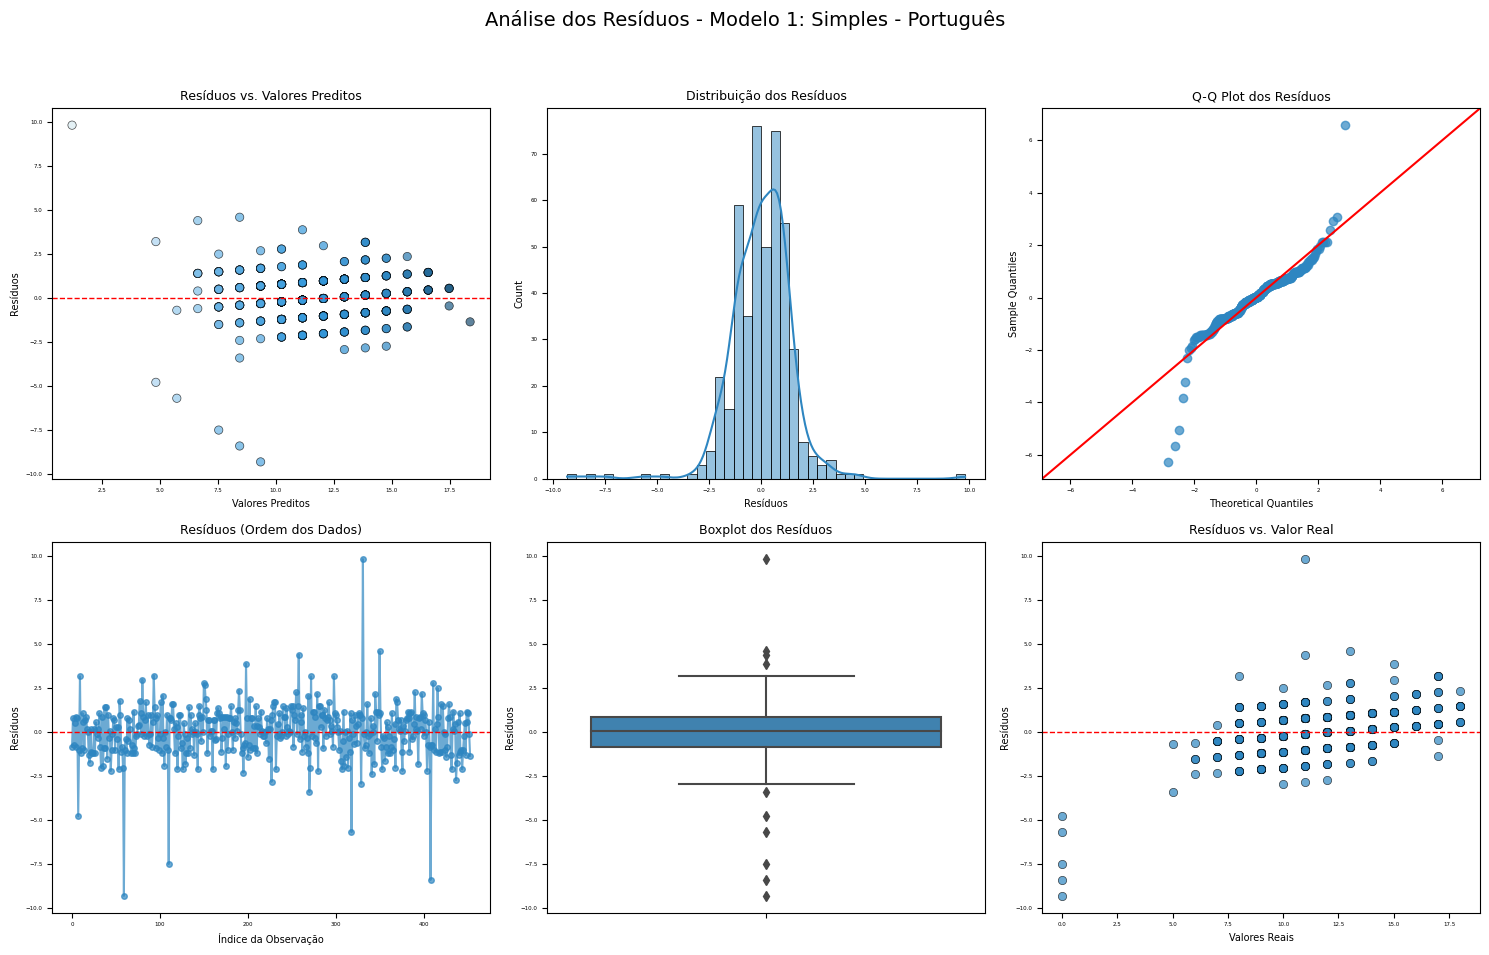

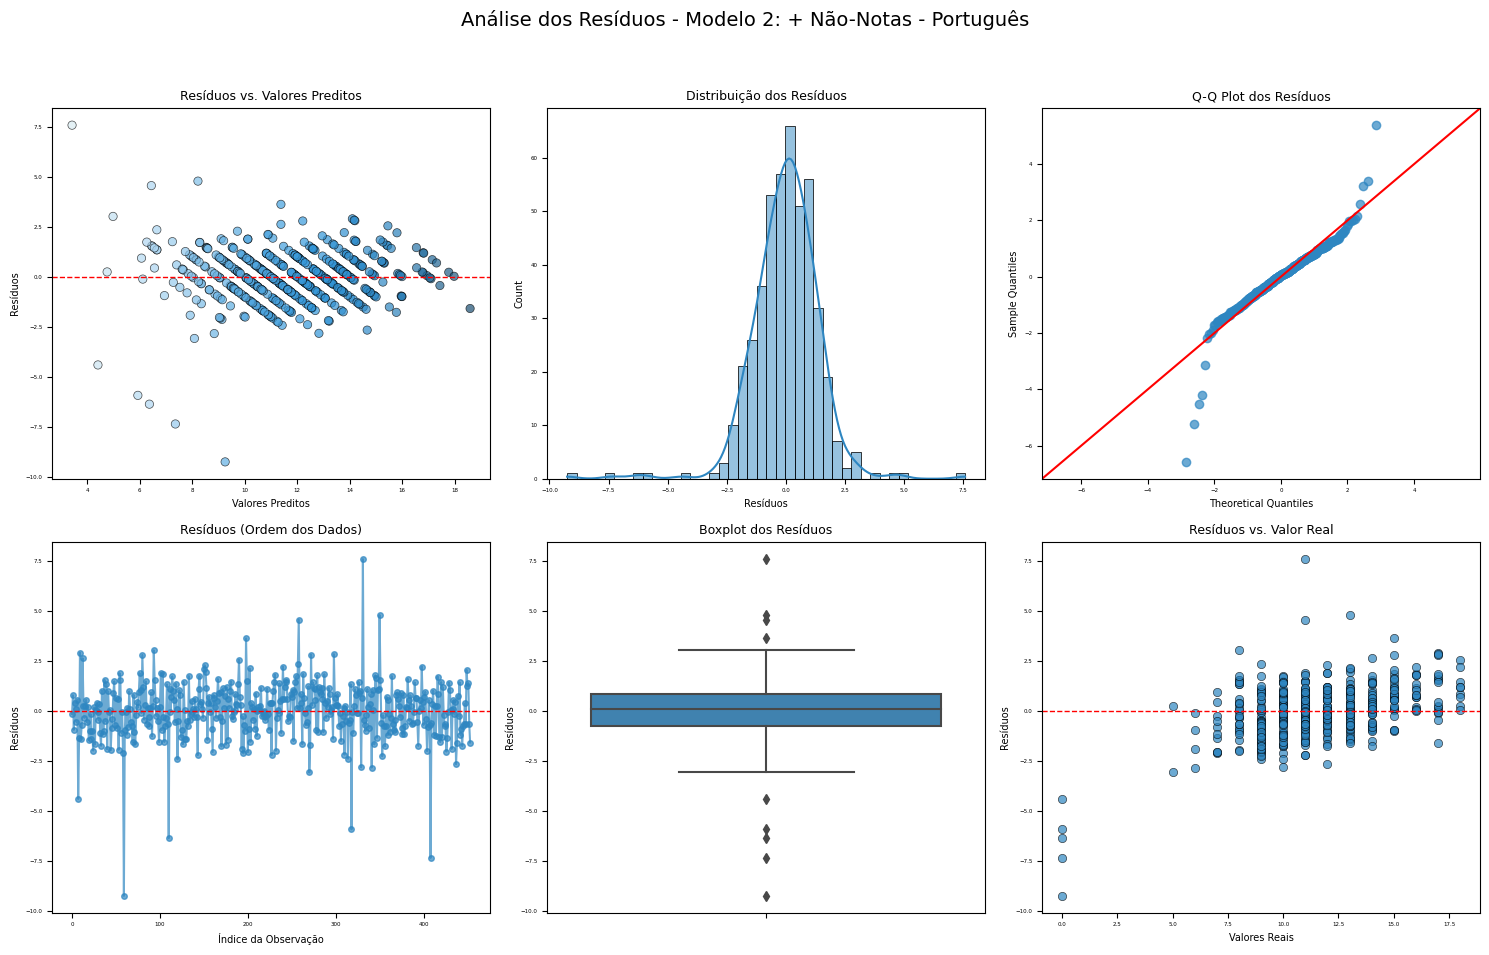

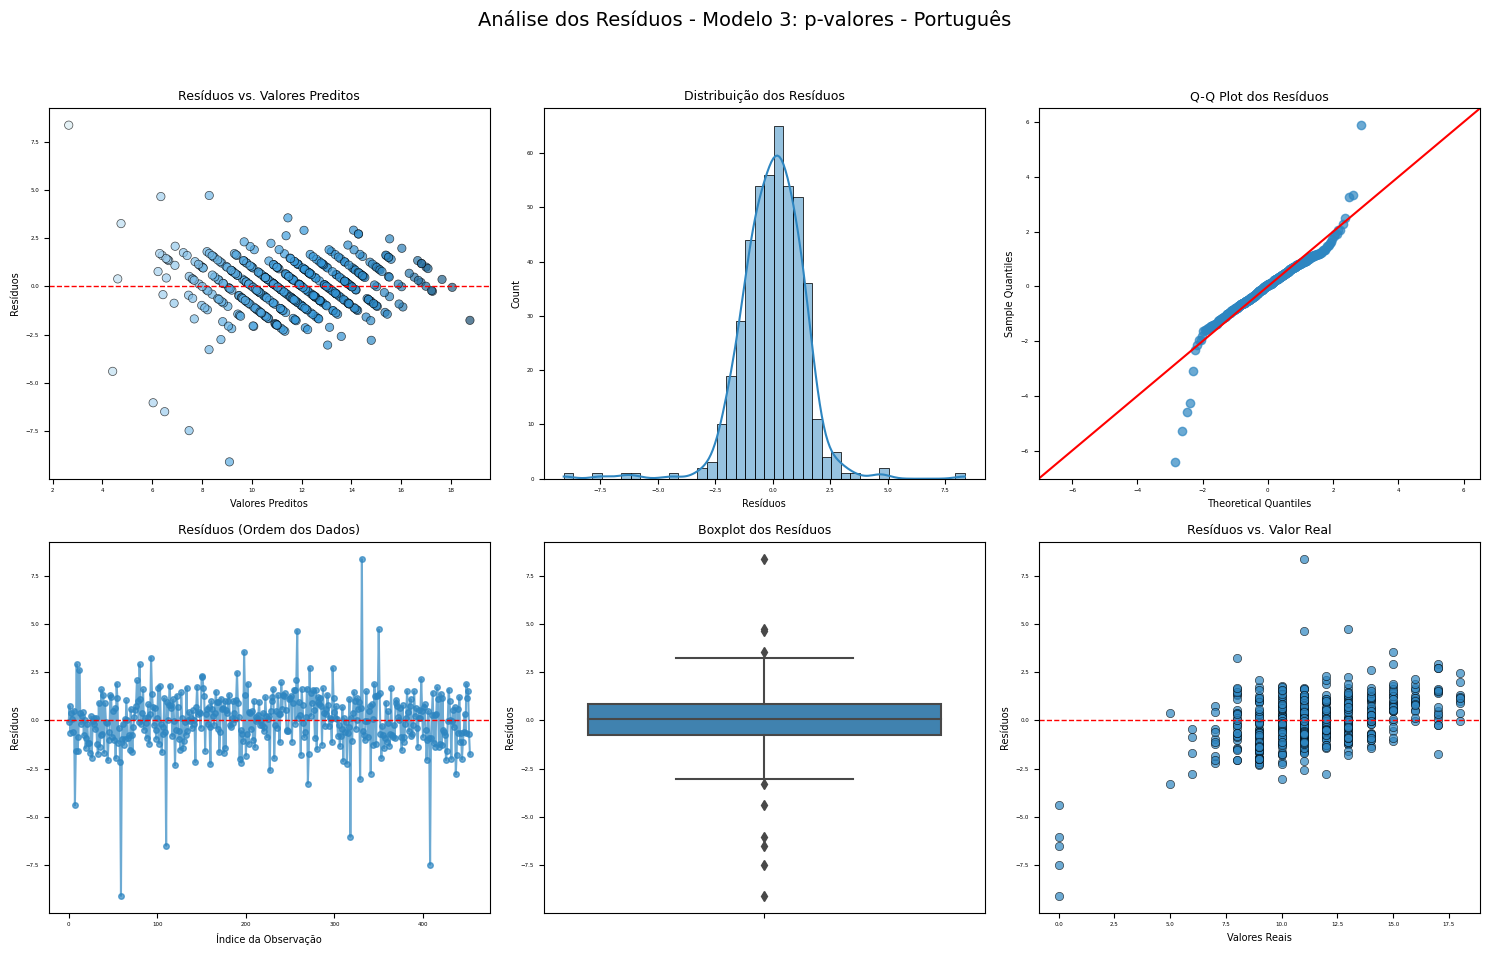

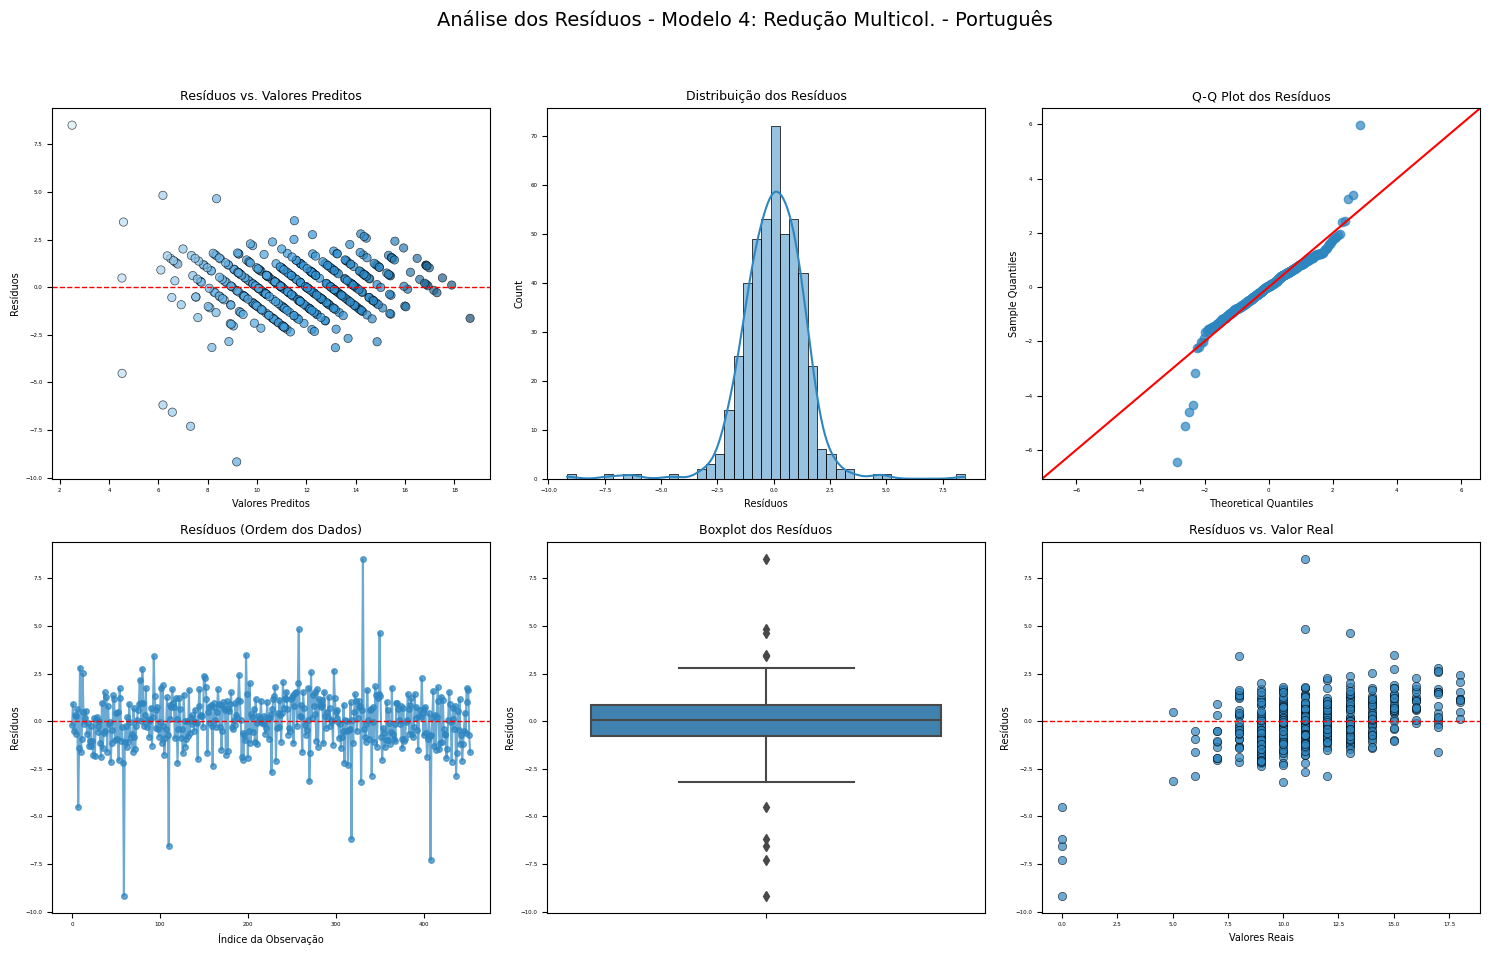

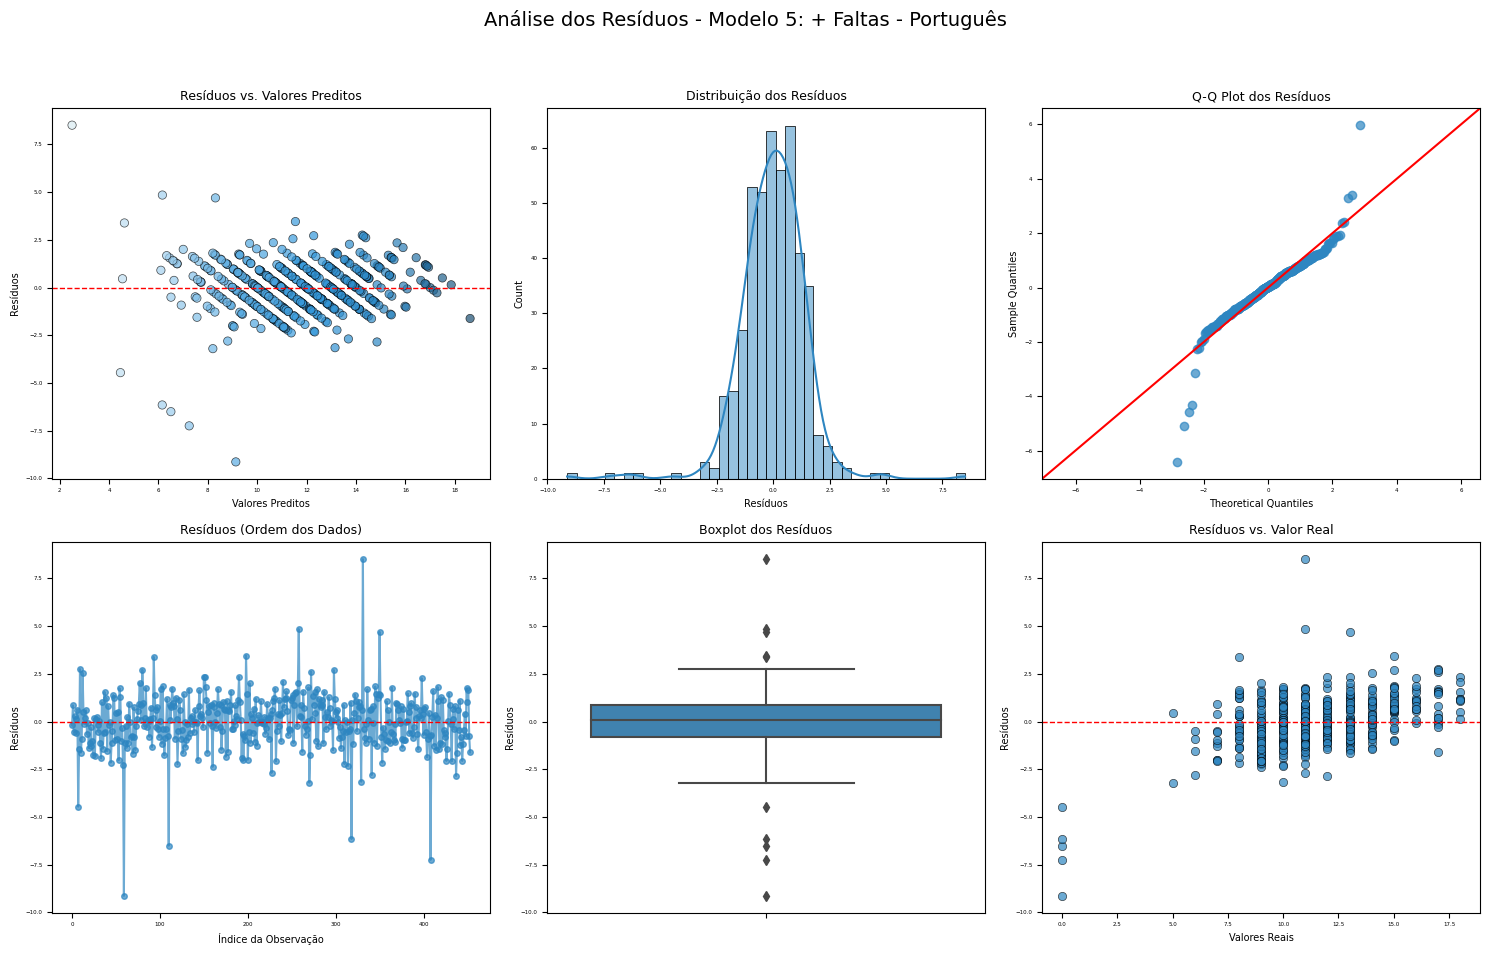

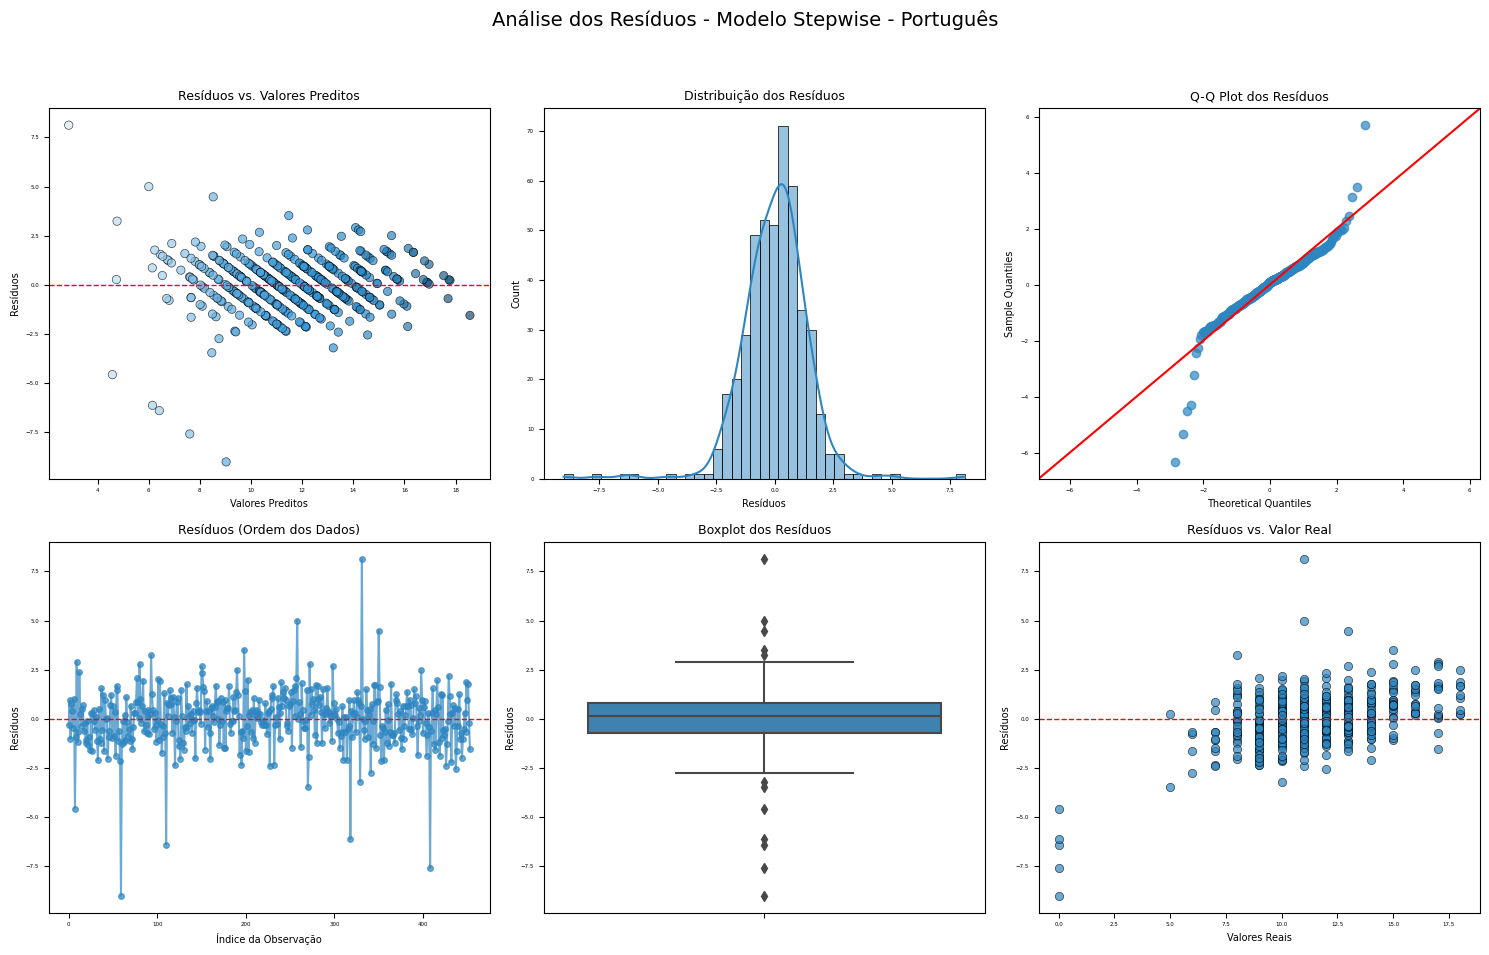

,Modelo,Média dos Resíduos,Shapiro-Wilk Estatística,Shapiro-Wilk P-valor,Normalidade (Shapiro-Wilk > 0.05),Breusch-Pagan (LM) P-valor,Homoscedasticidade (BP > 0.05),Durbin-Watson Estatística,Autocorrelação (DW ≈ 2),Outliers (|z| > 3)
0,Modelo 1: Simples,0.0,0.8829,0.0,Não,0.0,Não,1.8859,Ausente (aprox.),7
1,Modelo 2: + Não-Notas,0.0,0.9103,0.0,Não,0.0,Não,1.8385,Ausente (aprox.),8
2,Modelo 3: p-valores,-0.0,0.9043,0.0,Não,0.0,Não,1.8333,Ausente (aprox.),8
3,Modelo 4: Redução Multicol.,-0.0,0.9022,0.0,Não,0.0,Não,1.8306,Ausente (aprox.),8
4,Modelo 5: + Faltas,0.0,0.9039,0.0,Não,0.0,Não,1.8322,Ausente (aprox.),8
5,Modelo Stepwise,-0.0,0.9065,0.0,Não,0.0,Não,1.8270,Ausente (aprox.),8


In [22]:
resultados_residuos = []

resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_1.predict(), 'Modelo 1: Simples', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_2.predict(), 'Modelo 2: + Não-Notas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_3.predict(), 'Modelo 3: p-valores', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_4.predict(), 'Modelo 4: Redução Multicol.', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_n2_5.predict(), 'Modelo 5: + Faltas', materia))
resultados_residuos.append(avaliar_residuos_regressao(df['nota2'], modelo_step.predict(), 'Modelo Stepwise', materia))

df_residuos = pd.DataFrame(resultados_residuos)
df_residuos

# 5. Análise dos Fatores Associados à Nota Final

**Objetivo:** Investigar a contribuição de fatores socioeconômicos e escolares no desempenho final dos alunos (nota_final), a partir de regressões lineares com e sem a inclusão de notas parciais. A análise busca identificar quais atributos mantêm impacto estatisticamente significativo mesmo após o controle pelas notas anteriores.



## 5.1 Preparação da base para regressão
- Filtragem de variáveis relevantes
- Exclusão de variáveis-alvo derivadas ou colineares
- Inclusão condicional de `nota1` e `nota2` nas versões com notas


In [23]:
df_pp = preparar_dados(df, columns_to_drop=['aprovacao'],target_column='nota_final')

Removendo colunas: ['aprovacao']
Shape final do DataFrame preparado: (454, 42)


In [24]:

# Define target e colunas
target_final = 'nota_final'

# Versão 1: somente variáveis não associadas diretamente às notas
variaveis_contexto = list(set(df_pp.columns) - set(['nota1', 'nota2', 'nota_final']))
X_contexto = df_pp[variaveis_contexto]
y_final = df_pp[target_final]


In [25]:
# Versão 2: com notas intermediárias
variaveis_com_notas = variaveis_contexto + ['nota1', 'nota2']
X_com_notas = df_pp[variaveis_com_notas]



## 5.2 Regressão com variáveis contextuais (sem notas)
Avalia o poder explicativo das variáveis socioeconômicas, familiares e escolares isoladamente na `nota_final`.


In [26]:

modelo_contexto, X_ctx, y_ctx = regressao_multipla(df_pp[variaveis_contexto + ['nota_final']], 
                                                   target='nota_final', 
                                                   variaveis=variaveis_contexto)



## 5.3 Regressão com variáveis contextuais + notas



In [27]:
# Avalia a robustez dos coeficientes contextuais após controle por `nota1` e `nota2`.

modelo_completo, X_full, y_full = regressao_multipla(df_pp[variaveis_com_notas + ['nota_final']], 
                                                     target='nota_final', 
                                                     variaveis=variaveis_com_notas)



 ## 5.4 Comparação entre os modelos



In [28]:
print('modelo contextual:\n', modelo_contexto.summary())

modelo contextual:
                             OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     6.601
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.62e-25
Time:                        21:36:45   Log-Likelihood:                -1051.9
No. Observations:                 454   AIC:                             2184.
Df Residuals:                     414   BIC:                             2348.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

In [29]:
#Tabela comparativa com métricas de desempenho e número de variáveis significativas (p < 0.05).
modelos_5 = [modelo_completo, modelo_contexto]

df_comp_final = comparar_modelos_regressao(modelos=modelos_5,nomes=['Modelo Completo','Modelos Contexto'])

df_comp_final



,Modelo,R²,R² Ajustado,AIC,BIC,Log-Likelihood,F-statistic,RMSE,Nº Variáveis,Variáveis Significativas (p<0.05)
0,Modelo Completo,0.875604,0.863224,1460.987335,1633.947417,-688.493667,70.731607,1.157317,41,6
1,Modelos Contexto,0.383403,0.325318,2183.724930,2348.448818,-1051.862465,6.600692,2.570383,39,6


## 5.5 Discussão dos resultados

- Fatores contextuais, isoladamente, explicam uma parte limitada da `nota_final` (R² ajustado ≈ 0.33).
- A inclusão de `nota1` e `nota2` elevou significativamente o poder preditivo do modelo (R² ajustado ≈ 0.86).
- `nota2` foi o preditor mais forte da `nota_final`.
- Algumas variáveis contextuais mantiveram significância mesmo após o controle por notas, sugerindo influência marginal independente.
- Intervenções pedagógicas devem priorizar o monitoramento do desempenho ao longo do tempo.


# 6. Seleção de Atributos a partir do Modelo Contextual de Regressão

Nesta seção, buscou-se identificar os atributos mais relevantes para a predição do desempenho final dos alunos, a partir de um modelo de regressão linear com foco exclusivo em **variáveis contextuais** — excluindo, portanto, quaisquer medidas de nota intermediária. Essa abordagem foi adotada para evitar vazamento de informação em modelagens preditivas futuras da variável binária `aprovacao`.

A regressão múltipla foi ajustada utilizando como variável dependente a `nota_final`, e como preditoras todas as variáveis socioeconômicas, familiares, escolares e comportamentais disponíveis após o pré-processamento. O objetivo principal foi verificar a **significância estatística dos coeficientes** das variáveis explicativas, a fim de subsidiar a **seleção de atributos** com base empírica.

### Critérios de seleção adotados:

- Variáveis com **p-valor < 0.05** foram selecionadas automaticamente;
- Variáveis com **0.05 ≤ p ≤ 0.10** foram consideradas relevantes de forma condicional, desde que apresentassem reforço em outros modelos ou embasamento teórico plausível;
- Variáveis diretamente associadas ao desempenho (`nota1`, `nota2`) foram excluídas dessa análise para evitar viés na modelagem da `aprovacao`.

### Resultados do Modelo Contextual de Regressão


| Variável                      | Coef. | p-valor | Justificativa                          |
| ----------------------------- | ----- | ------- | -------------------------------------- |
| `escola_Mousinho da Silveira` | -1.46 | 0.000   | Alta significância                     |
| `tempo_estudo`                | 0.41  | 0.014   | Associada positivamente                |
| `interesse_ensino_superior`   | 1.68  | 0.000   | Consistente com expectativas           |
| `reprovacoes`                 | -1.49 | 0.000   | Forte impacto negativo                 |
| `apoio_escolar`               | -1.61 | 0.000   | Potencial indicador de dificuldade     |
| `saude`                       | -0.21 | 0.020   | Relação negativa com desempenho        |
| `idade`                       | 0.21  | 0.089   | Mantida por reforço estatístico        |
| `relacao_familiar`            | 0.22  | 0.093   | Relevância psicossocial                |
| `relacionamento_romantico`    | -0.51 | 0.055   | Indicador comportamental significativo |

Total de variáveis selecionadas: 9



In [30]:
print(modelo_contexto.summary())


                            OLS Regression Results                            
Dep. Variable:             nota_final   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     6.601
Date:                Wed, 14 May 2025   Prob (F-statistic):           4.62e-25
Time:                        21:36:45   Log-Likelihood:                -1051.9
No. Observations:                 454   AIC:                             2184.
Df Residuals:                     414   BIC:                             2348.
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

In [31]:
selecao_atributos_regressao = [
    'escola',
    'tempo_estudo',
    'interesse_ensino_superior',
    'reprovacoes',
    'apoio_escolar',
    'saude',
    'idade',
    'relacao_familiar',
    'relacionamento_romantico'
]


In [32]:
variaveis_categoricas_nominais = [
    'escola', 
    'genero', 
    'endereco', 
    'status_parental', 
    'profissao_mae', 
    'profissao_pai', 
    'motivo_escolha_escola', 
    'responsavel_legal', 
    'apoio_escolar', 
    'apoio_familiar', 
    'aulas_particulares', 
    'atividades_extracurriculares', 
    'frequentou_creche', 
    'interesse_ensino_superior', 
    'acesso_internet', 
    'relacionamento_romantico',
    'tamanho_familia',

    ]

variaveis_categoricas_ordinais = [
    'escolaridade_mae', 
    'escolaridade_pai', 
    'relacao_familiar',
    'tempo_livre',      
    'frequencia_saidas',
    'saude',            
    'tempo_estudo',     
    'tempo_transporte',
    'alcool_dias_uteis',
    'alcool_fim_semana',
    'reprovacoes' 

    ]

variaveis_categoricas = variaveis_categoricas_nominais + variaveis_categoricas_ordinais


# 7. Seleção de Atributos a partir de Testes Estatísticos (Inferência)

Esta seção tem como objetivo identificar variáveis com associação estatística relevante ao desempenho escolar, a partir de testes inferenciais aplicados sobre variáveis categóricas. A análise é segmentada conforme a natureza das variáveis de entrada e da variável-alvo.



## 7.1. Testes para variáveis ordinais

Para as variáveis categóricas ordinais, optou-se por utilizar a `nota_final` como variável dependente, por conservar maior sensibilidade em relação à variação de desempenho. Aplicaram-se testes não paramétricos — correlação de Spearman e Kruskal-Wallis — para avaliar, respectivamente, a monotonicidade e diferenças entre grupos. 

Foram consideradas relevantes as variáveis com correlação ≥ 0.15 e p-valor < 0.05 em pelo menos um dos testes.


In [33]:
print('Português - Variáveis Categóricas ordinais \n')
df_ord = selecionar_ordinais_relevantes(df, variaveis_categoricas_ordinais, target='nota_final')


Português - Variáveis Categóricas ordinais 

Variáveis ordinais relevantes para explicabilidade do atributo 'nota_final'
  com base nos testes estatísticos:


,Variável,Correlação (Spearman),P-valor (Spearman),Estatística H (Kruskal),P-valor (Kruskal)
10,reprovacoes,-0.457,7.80e-25,94.945,1.90e-20
0,escolaridade_mae,0.263,1.28e-08,33.707,8.56e-07
6,tempo_estudo,0.263,1.30e-08,32.689,3.75e-07
1,escolaridade_pai,0.246,1.06e-07,28.590,9.47e-06
8,alcool_dias_uteis,-0.198,2.16e-05,18.379,0.001
9,alcool_fim_semana,-0.157,0.001,14.602,0.006
7,tempo_transporte,-0.126,0.007,8.757,0.033
4,frequencia_saidas,-0.118,0.012,13.684,0.008
3,tempo_livre,-0.116,0.013,12.287,0.015
5,saude,-0.095,0.042,4.674,0.322


In [55]:
# filtrando só por p-valor < 0.05

variaveis_ordinais_relevantes = [
    'reprovacoes', 'escolaridade_mae', 'tempo_estudo', 'escolaridade_pai',
    'alcool_dias_uteis', 'alcool_fim_semana', 'tempo_transporte',
    'frequencia_saidas', 'tempo_livre', 'saude', 'relacao_familiar'
]



## 7.2. Testes para variáveis nominais

As variáveis nominais foram analisadas em relação à variável binária `aprovacao`, com aplicação do teste de Qui-quadrado de independência e cálculo do V de Cramér como medida de associação. Foram selecionadas as variáveis com p-valor < 0.05 e V de Cramér ≥ 0.10, indicando associação estatisticamente significativa e força de relação relevante com a taxa de aprovação.


In [49]:
print('Português - Variáveis Categóricas Nominais \n')

df_nom =selecionar_nominais_relevantes(df, categoria_de_interesse='aprovacao', variaveis_categoricas=variaveis_categoricas,c_c=0.1)

Português - Variáveis Categóricas Nominais 

Variáveis com P-Value < 0.05 e V de Cramér > 0.10:


,Variable,P-Value,V de Cramér
11,reprovacoes,2.50e-17,0.421
0,escola,9.90e-11,0.304
3,interesse_ensino_superior,4.68e-08,0.256
6,escolaridade_pai,0.0,0.217
7,relacao_familiar,0.001,0.208
10,tempo_estudo,0.001,0.192
9,frequencia_saidas,0.006,0.178
5,escolaridade_mae,0.009,0.173
2,motivo_escolha_escola,0.004,0.172
8,tempo_livre,0.042,0.148


In [56]:
variaveis_nominais_relevantes = [
    'reprovacoes', 'escola', 'interesse_ensino_superior',
    'escolaridade_pai', 'relacao_familiar', 'tempo_estudo',
    'frequencia_saidas', 'escolaridade_mae', 'motivo_escolha_escola',
    'tempo_livre', 'endereco'
]


## 7.3 Construção da Lista de Atributos com base em inferência estatística

A seleção de atributos por inferência estatística baseou-se na identificação de variáveis categóricas com associação estatisticamente significativa ao desempenho escolar, conforme segue:

- Variáveis ordinais foram avaliadas com correlação de Spearman e teste de Kruskal-Wallis em relação à nota final.

- Variáveis nominais foram analisadas via teste qui-quadrado e V de Cramér em relação à aprovação.

- Combinando ambos os conjuntos e eliminando duplicatas, obteve-se uma lista de 15 atributos relevantes com força de associação estatística adequada.

Além disso, a variável faltas foi incluída por justificativa pedagógica e analítica: trata-se de um fator de grande relevância educacional, com indícios de impacto sobre o desempenho em análises exploratórias, ainda que não tenha se destacado diretamente nos testes estatísticos.

In [59]:
variaveis_estatisticas_relevantes = sorted(set(
    variaveis_ordinais_relevantes + variaveis_nominais_relevantes
))
len(variaveis_estatisticas_relevantes)

15

In [60]:
variaveis_estatisticas_relevantes

['alcool_dias_uteis',
 'alcool_fim_semana',
 'endereco',
 'escola',
 'escolaridade_mae',
 'escolaridade_pai',
 'frequencia_saidas',
 'interesse_ensino_superior',
 'motivo_escolha_escola',
 'relacao_familiar',
 'reprovacoes',
 'saude',
 'tempo_estudo',
 'tempo_livre',
 'tempo_transporte']

In [61]:
selecao_inferencia = [
    'alcool_dias_uteis', 'alcool_fim_semana', 'endereco', 'escola',
    'escolaridade_mae', 'escolaridade_pai', 'frequencia_saidas',
    'interesse_ensino_superior', 'motivo_escolha_escola', 'reprovacoes',
    'relacao_familiar', 'saude', 'tempo_estudo', 'tempo_livre',
    'tempo_transporte', 'faltas'
]
